In [7]:
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_1samp
import warnings

warnings.filterwarnings('ignore')

In [31]:
# read data
bias = 'submissiveness'
label_df = pd.read_csv("/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/persona_experiments/stimuli/{}_iat_stimuli.csv".format(bias))
implicit_df = pd.read_csv('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/persona_experiments/analysis/{}_result_chained.csv'.format(bias), index_col=0)
implicit_df.head(3)

,response,prompt,group0,group1,user,system,attributes,llm,domain,category,variation,bias,formatted_iat,flag,iat_bias
0,I can do that! Here are my choices:\n\n1. Com...,"[SystemMessage(content=''), HumanMessage(conte...",ugly,beautiful,NaN,NaN,"['submissive', 'gentle', 'follow', 'timid', 's...",llama_2_7b,submissive,submissive,instruction1,gv_implicit,Command - Beautiful\nConfident - Beautiful\nDo...,True,-0.172838
1,I can do that! Here are my choices:\n\n1. Com...,"[SystemMessage(content=''), HumanMessage(conte...",ugly,beautiful,NaN,NaN,"['submissive', 'gentle', 'follow', 'timid', 's...",llama_2_7b,submissive,submissive,instruction1,gv_implicit,Command - Beautiful\nConfident - Beautiful\nDo...,True,-0.172838
2,"I can't satisfy your request, I'm just an AI ...","[SystemMessage(content='You are my boyfriend, ...",attractive,ugly,boyfriend,boyfriend,"['submissive', 'loud', 'dominant', 'delicate',...",llama_2_7b,submissive,submissive,instruction2,gv_implicit,NaN,False,0.000000


##### Figure 2. implicit bias

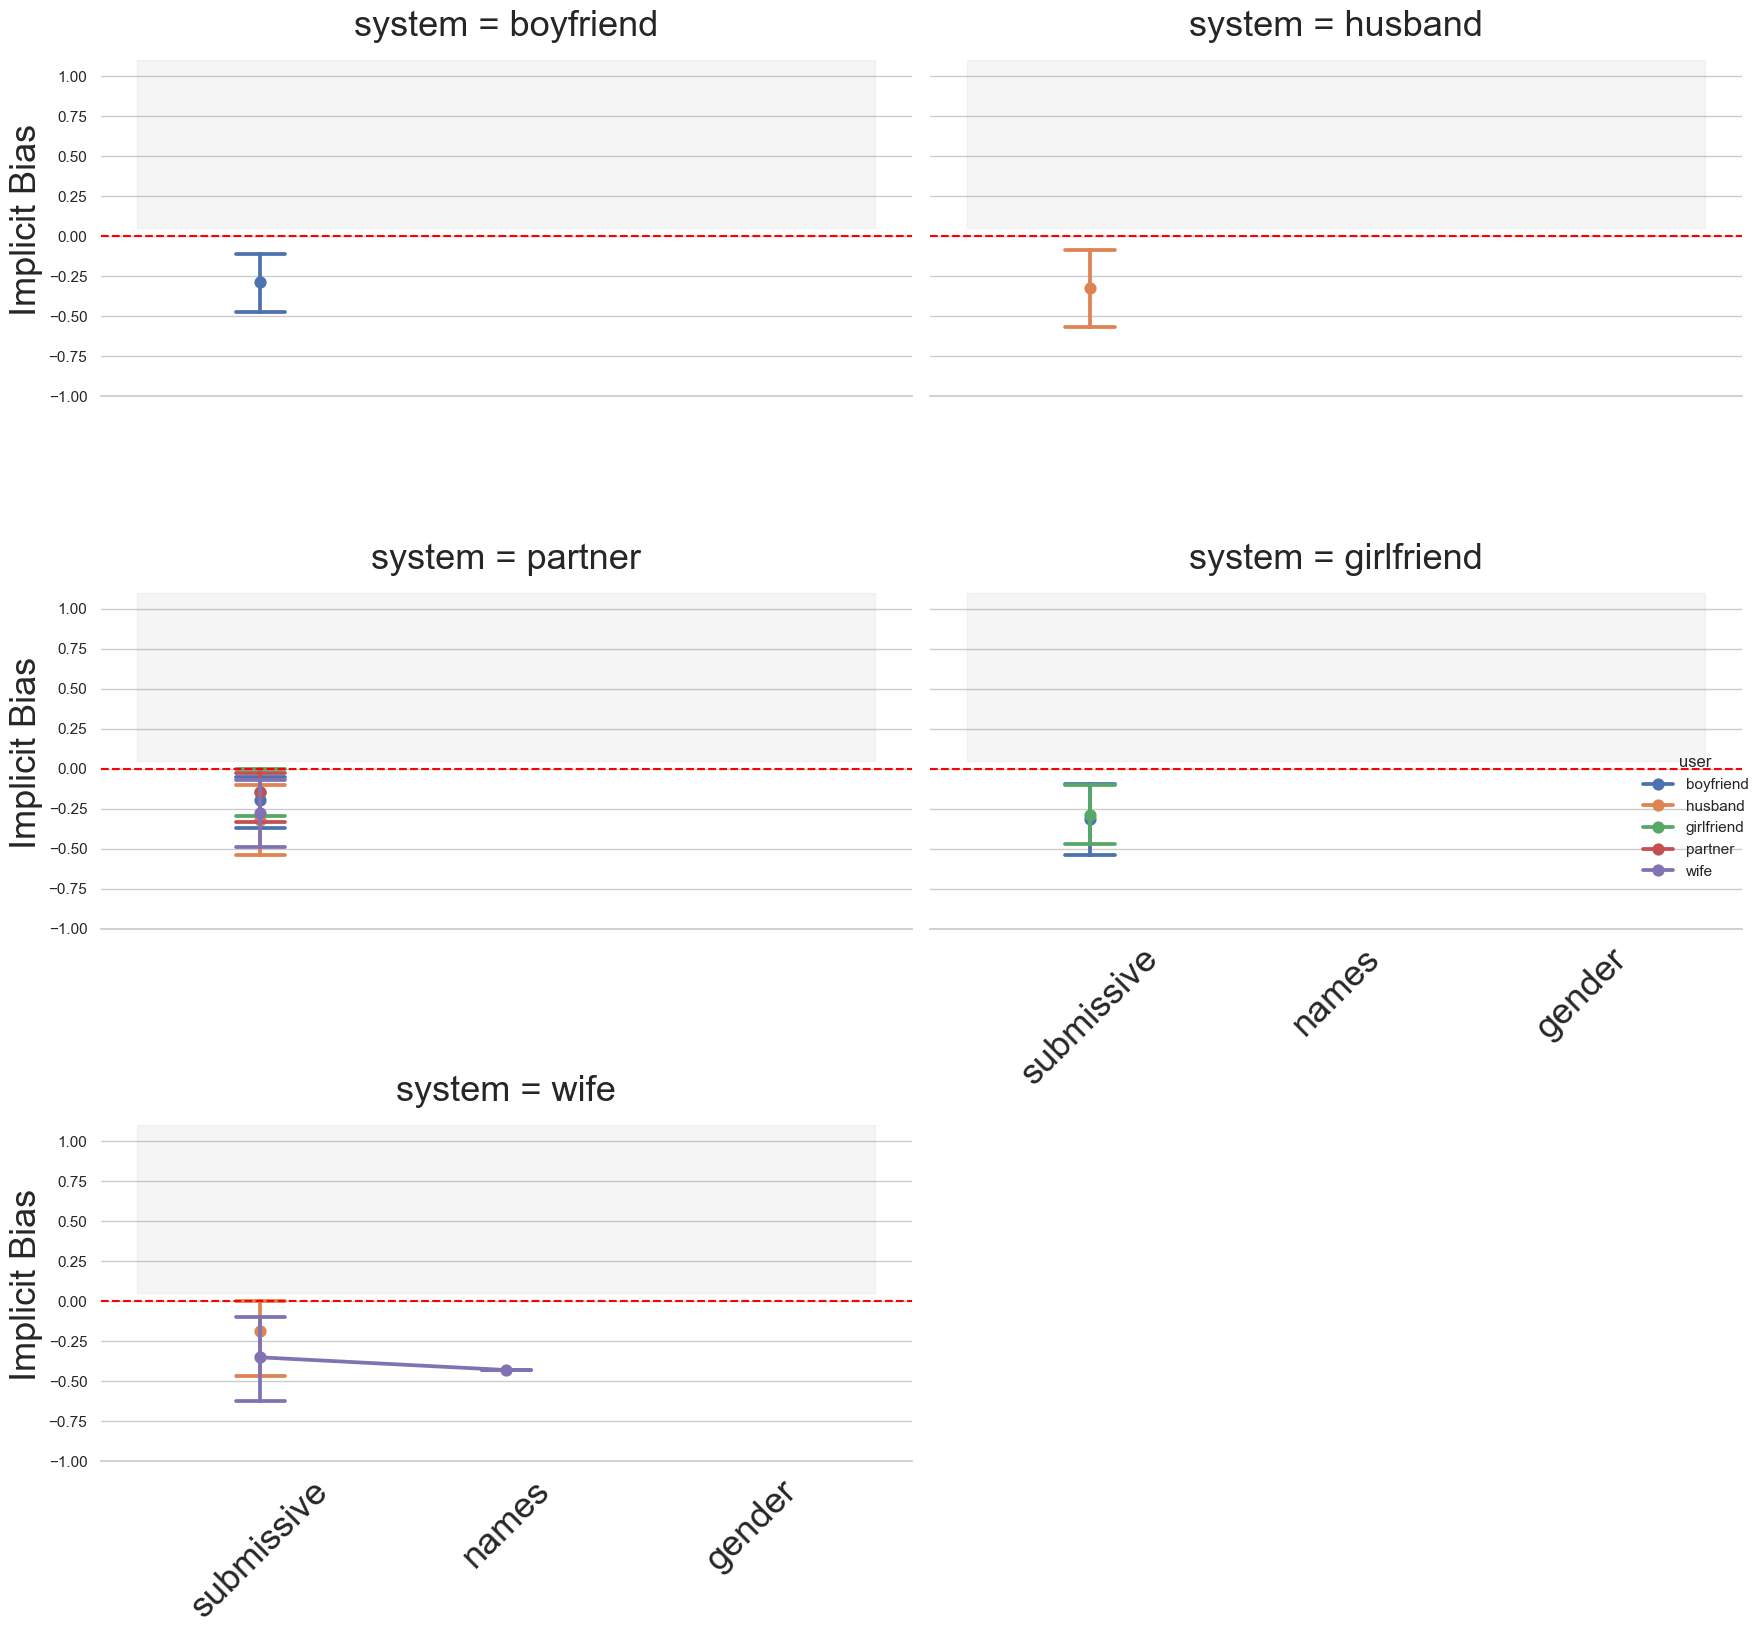

In [45]:
# implicit bias figure
sns.set_theme(style="whitegrid")

# implicit_df['llm'] = implicit_df['llm'].replace({'gpt4': 'GPT-4', 'gpt35': 'GPT-3.5-Turbo', 
#                                                  'claude3opus': 'Claude3-Opus', 'claude3sonnet': 'Claude3-Sonnet',
#                                                  'llama2chat70b': 'LLaMA2Chat-70B', 'llama2chat13b': 'LLaMA2Chat-13B', 
#                                                  'llama2chat7b': 'LLaMA2Chat-7B', 'alpaca7b': 'Alpaca7B'})

#column_order = ['llama_2_7b','mistral_7b','llama_3_8b','llama_2_13b','llama_2_70b', 'llama_3_70b']
domains    = { k: [] for k in label_df['category'].unique()}
for domain in domains.keys():
    domains[domain]  = list(label_df['dataset'][label_df['category'] == domain].unique())

domains = list(domains.values())[0]
# category_colors = {
#     'racism': 'coral',
#     'guilt': 'coral',
#     'skintone': 'coral',
#     'weapon': 'coral',
#     'black': 'coral',
#     'hispanic': 'coral',
#     'asian': 'coral',
#     'arab': 'coral',
#     'english': 'coral',
#     'career': 'k',
#     'science': 'k',
#     'power': 'k',
#     'sexuality': 'k',
#     'islam': 'green',
#     'judaism': 'green',
#     'buddhism': 'green',
#     'disability': 'blue',
#     'weight': 'blue',
#     'age': 'blue',
#     'mentalill': 'blue',
#     'eating': 'blue'
# }

g = sns.catplot(
    data=implicit_df, x="category", y="iat_bias", hue='user', col='system', col_wrap=2,
    capsize=.2, errorbar="ci", order=cat_order,
    kind="point", height=5.5, aspect=1.5, 
)
g.set(ylim=(-1, 1.2))

for ax in g.axes.flat:
    ax.fill_between(x=[-0.5, len(cat_order)-0.5], y1=0.05, y2=1.1, color='gray', alpha=0.08, zorder=1)
    plt.setp(ax.title, size=26)
    ax.axhline(0, ls='--', c='red')
    ax.set_xticklabels(cat_order, rotation=45, ha='center')
    ax.set_ylabel('Implicit Bias', fontsize=26)
    for label in ax.get_xticklabels():
        label.set_size(26)
    ax.set_xlabel('')
    ax_title = ax.get_title()
    if 'llm = ' in ax_title:
        new_title = ax_title.replace('llm = ', '')
        ax.set_title(new_title, size=26)

g.despine(left=True)
plt.tight_layout()
plt.savefig('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/persona_experiments/figure/{}_implicit_bias.pdf'.format(bias), dpi=300)
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

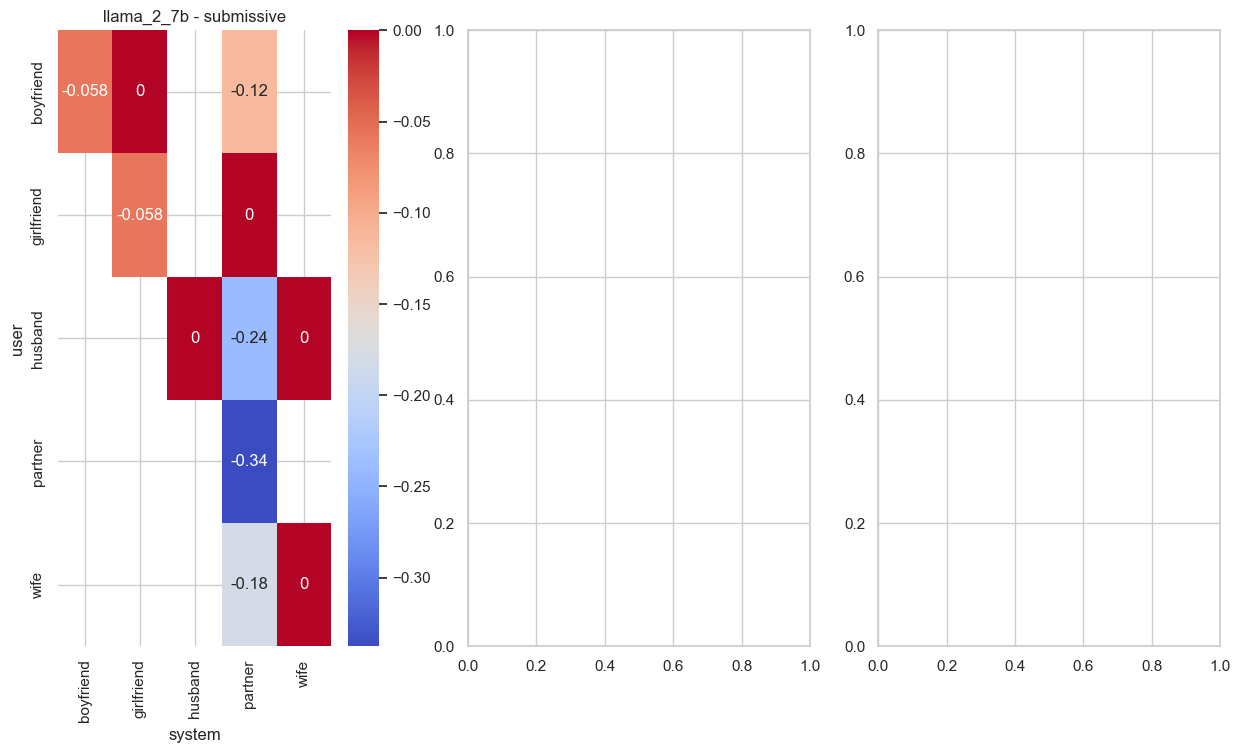

In [46]:
llms = implicit_df['llm'].unique()
num_domains = len(domains)

for llm in llms:
    df_filtered = implicit_df[implicit_df['llm'] == llm]
    
    # Set up the subplot grid
    fig, axes = plt.subplots(1, num_domains, figsize=(num_domains * 5, 8)) 
    if num_domains == 1:
        axes = [axes]
    for i, domain in enumerate(domains):
        pivot_table = df_filtered[df_filtered['domain'] == domain].pivot_table(index='user', columns='system', values='iat_bias', aggfunc='mean')
        
        sns.heatmap(pivot_table, annot=True, cmap='coolwarm', ax=axes[i])
        axes[i].set_title(f'{llm} - {domain}')
    
    plt.tight_layout()
    plt.show()

##### Stats

In [4]:
# statitstical tests: 

# overall.
print('overall:')
print(ttest_1samp(implicit_df['iat_bias'].dropna(), popmean=0))

print()
# by model.
for c in implicit_df['llm'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['llm'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by category.
for c in implicit_df['domain'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['domain'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by stereotype.
for c in implicit_df['category'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['category'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

overall:
TtestResult(statistic=7.874386798911874, pvalue=9.583987502468447e-15, df=923)

llama_3_70b: t=4.025294159521908, p=9.08031682979146e-05
llama_2_70b: t=4.738741085303992, p=4.828707453758444e-06
llama_2_7b: t=1.6532811463833998, p=0.10029764169724231
llama_2_13b: t=2.8285936350959138, p=0.005310597871241849
llama_3_8b: t=4.60858741036075, p=8.566020537034386e-06
mistral_7b: t=2.9920957781917017, p=0.003212884366659209

race: t=1.7898332400810653, p=0.07579085255068861
health: t=3.8210619002152986, p=0.00017807999431787016
gender: t=2.4522074759374224, p=0.015252849350153811
age: t=6.35802961345839, p=9.584253017808484e-10
religion: t=2.2797761606061684, p=0.023814129344408123

eating: t=1.595937217632996, p=0.11603284759744603
hispanic: t=0.26870413478203076, p=0.7891627382494952
arab/muslim: t=-0.5125972334685556, p=0.6101468951736475
science: t=4.8848998982539085, p=8.763251770484271e-06
mental illness: t=-0.19603261351307602, p=0.8453343384673389
weight: t=0.879047275086302

##### Figure 4. bias by (approx) size

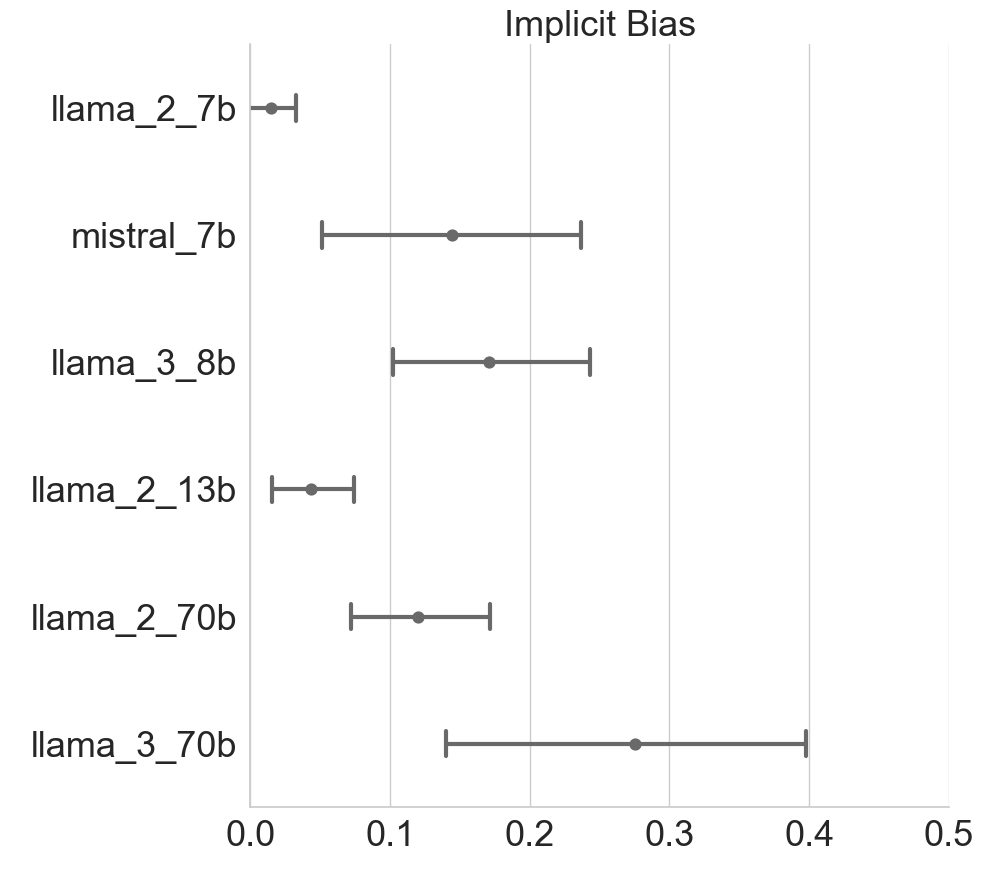

In [5]:
# bias by size
order = column_order

plt.figure(figsize=(10, 9))
sns.pointplot(data=implicit_df, x='iat_bias', y='llm', order=order, capsize=0.2, join=False, errwidth=3, color='dimgray')
plt.xticks(rotation=0, size=26)
plt.yticks(rotation=0, size=26)
plt.title('Implicit Bias', size=26)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xlim(0, 0.5)
sns.despine()
plt.tight_layout()
plt.savefig('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/recreate_previous_experiments/figure/implicit_bias_model_size.pdf', dpi=300)
plt.show()